In [5]:
from google.colab import files
uploaded = files.upload()


Saving weatherAUS.csv to weatherAUS (1).csv


In [ ]:
# --- Kodblock 1 Import:
import pandas as pd

# Läs in CSV-filen
df = pd.read_csv("weatherAUS.csv")

# Visa de första 5 raderna
df.head()


In [ ]:
# --- Kodblock 2: Ta bort kolumner med mycket saknade värden
df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1, inplace=True)

# Ta bort rader som saknar värden i viktiga kolumner
df.dropna(subset=['RainToday', 'RainTomorrow', 'Humidity3pm'], inplace=True)

# Fyll andra saknade värden med median
df.fillna(df.median(numeric_only=True), inplace=True)

# Konvertera 'RainToday' och 'RainTomorrow' till binära (0/1)
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Visa förändrade data
df.head()


In [9]:
# --- Kodblock 3: Kolumner vi vill använda som input till modellen
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity3pm', 'WindSpeed9am', 'WindSpeed3pm', 'RainToday']

# Målvariabeln
target = 'RainTomorrow'

# Skapa X (inputs) och y (output)
X = df[features]
y = df[target]


In [40]:
# --- Kodblock 3.1: Feature Engineering ---

# Se till att 'Date' är i datetime-format
df['Date'] = pd.to_datetime(df['Date'])

# Skapa nya kolumner som kan hjälpa modellen
df['TempDiff']  = df['MaxTemp'] - df['MinTemp']       # Temperatur-differens
df['Weekday']   = df['Date'].dt.weekday               # Veckodag (0=måndag,... 6=söndag)
df['Month']     = df['Date'].dt.month                 # Månad (1–12)
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)  # Helgflagga

# Kontrollera att de nya kolumnerna lagts till
print(df[['TempDiff', 'Weekday', 'Month', 'IsWeekend']].head())


   TempDiff  Weekday  Month  IsWeekend
0       9.5        0     12          0
1      17.7        1     12          0
2      12.8        2     12          0
3      18.8        3     12          0
4      14.8        4     12          0


In [46]:
# --- Kodblock 4:

from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Lista av features (endast numeriska kolumner)
features = [
    'MinTemp', 'MaxTemp', 'Rainfall',
    'Humidity3pm', 'WindSpeed9am', 'WindSpeed3pm',
    'RainToday',
    'TempDiff', 'Weekday', 'Month', 'IsWeekend'
]

# 2. X = alla valda features, y = target
X = df[features]
y = df['RainTomorrow']

# 3. Dela upp i träning/test, och plocka ut Location som egen array
X_train, X_test, y_train, y_test, loc_train, loc_test = train_test_split(
    X, y, df['Location'],
    test_size=0.2,
    random_state=42
)

# 4. Omvandla X_test till DataFrame för att behålla kolumnnamn
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# 5. Kontrollera att allt ser rätt ut
print("Features i X:", X.columns.tolist())
print("Antal träningsrader:", len(X_train), "Antal testrader:", len(X_test))
print("Exempel på platser i loc_test:", loc_test.unique()[:5])



Features i X: ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity3pm', 'WindSpeed9am', 'WindSpeed3pm', 'RainToday', 'TempDiff', 'Weekday', 'Month', 'IsWeekend']
Antal träningsrader: 109828 Antal testrader: 27458
Exempel på platser i loc_test: ['Katherine' 'Watsonia' 'Portland' 'NorfolkIsland' 'Ballarat']


In [ ]:
# --- Kodblock 4.1: Jämför baseline vs engineered features För VG ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Baseline: bara ursprungliga features
features_base = ['MinTemp','MaxTemp','Rainfall','Humidity9am','Humidity3pm','WindSpeed9am','WindSpeed3pm','RainToday']
X_base = df[features_base]
y = df['RainTomorrow']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y, test_size=0.2, random_state=42)

rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_base.fit(Xb_train, yb_train)
yb_pred = rf_base.predict(Xb_test)
acc_base = accuracy_score(yb_test, yb_pred)

# Engineered: inkludera nya features
features_eng = features_base + ['TempDiff','Weekday','Month','IsWeekend']
X_eng = df[features_eng]
Xe_train, Xe_test, ye_train, ye_test = train_test_split(
    X_eng, y, test_size=0.2, random_state=42)

rf_eng = RandomForestClassifier(n_estimators=100, random_state=42)
rf_eng.fit(Xe_train, ye_train)
ye_pred = rf_eng.predict(Xe_test)
acc_eng = accuracy_score(ye_test, ye_pred)

print(f"Baseline RF accuracy:  {acc_base:.3f}")
print(f"Engineered RF accuracy: {acc_eng:.3f}")


In [47]:
# --- Kodblock 5:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=3,
    scoring='accuracy', n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

print("Bästa parametrar:", random_search.best_params_)
print("Bästa accuracy på träning (CV):", random_search.best_score_)

# Använd bästa modellen framöver:
model = random_search.best_estimator_


Bästa parametrar: {'n_estimators': 150, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 10}
Bästa accuracy på träning (CV): 0.8397585401173523


In [48]:
# --- Kodblock 6:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Gör prediktioner på testdata
y_pred = model.predict(X_test)

# Beräkna accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Visa klassificeringsrapport
print("Klassificeringsrapport:")
print(classification_report(y_test, y_pred))

# Visa förvirringsmatris
print("Förvirringsmatris:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8393182314808071
Klassificeringsrapport:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     21385
           1       0.75      0.41      0.53      6073

    accuracy                           0.84     27458
   macro avg       0.80      0.69      0.72     27458
weighted avg       0.83      0.84      0.82     27458

Förvirringsmatris:
[[20546   839]
 [ 3573  2500]]


In [54]:
# --- Kodblock 7: Alternativ modell – Gradient Boosting (engineered features) ---

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Träna Gradient Boosting på samma data (X_train innehåller alla dina features, inklusive TempDiff, Weekday, Month, IsWeekend)
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Gör prediktioner
y_pred_gb = gb.predict(X_test)

# Beräkna accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting accuracy (engineered):", accuracy_gb)

# Visa klassificeringsrapport
print("\nKlassificeringsrapport för GB:")
print(classification_report(y_test, y_pred_gb))




Gradient Boosting accuracy (engineered): 0.8382620729841941

Klassificeringsrapport för GB:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     21385
           1       0.74      0.42      0.53      6073

    accuracy                           0.84     27458
   macro avg       0.79      0.69      0.72     27458
weighted avg       0.83      0.84      0.82     27458



### Jämförelse och slutsats

Den tränade modellen med feature engineering (både Random Forest och Gradient Boosting) presterade snarlikt i jämförelse med baseline-modellen med en accuracy nära 84%.


In [55]:
# --- Kodblock 8: Använd loc_test som platsnamn
locations = loc_test.reset_index(drop=True)

predictions_df = pd.DataFrame({
    'Plats': locations,
    'Kommer det regna?': y_pred
})

predictions_df['Kommer det regna?'] = predictions_df['Kommer det regna?'].map({0: 'Nej', 1: 'Ja'})

print("Exempel på prognos för imorgon:\n")
print(predictions_df.head(15))


Exempel på prognos för imorgon:

            Plats Kommer det regna?
0       Katherine               Nej
1        Watsonia               Nej
2        Portland                Ja
3   NorfolkIsland               Nej
4        Ballarat               Nej
5       GoldCoast               Nej
6          Albany               Nej
7      Townsville               Nej
8        Ballarat               Nej
9          Hobart               Nej
10   MountGambier               Nej
11       Adelaide               Nej
12           Sale               Nej
13         Cairns               Nej
14       Watsonia               Nej


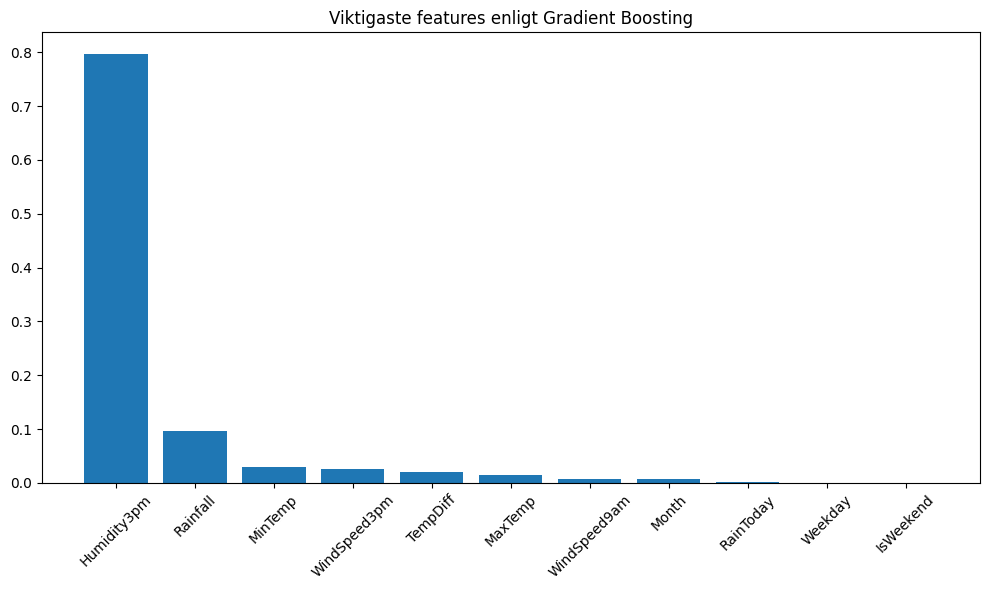

In [56]:
# --- Kodblock 9: Feature Importance för Gradient Boosting ---
import numpy as np
import matplotlib.pyplot as plt

# Kolla feature importances från modellen (Gradient Boosting)
feature_importances = gb.feature_importances_
features = X_train.columns  # Om du använder Xe_train, byt ut till Xe_train.columns

# Sortera importances
indices = np.argsort(feature_importances)[::-1]

# Rita stapeldiagram
plt.figure(figsize=(10,6))
plt.title("Viktigaste features enligt Gradient Boosting")
plt.bar(range(len(features)), feature_importances[indices], align="center")
plt.xticks(range(len(features)), features[indices], rotation=45)
plt.tight_layout()
plt.show()
